In [ ]:
import pandas as pd
from collections import defaultdict
import numpy as np
import random


df = pd.DataFrame({
    "A": [1.0, 1.5, 2.0, 2.5, 8.4],
    "B": [5.0, 5.5, 6.0, 6.5, 2.6],
    "D": [6.0, 2.5, 1.6, 5.4, 2.6],
    "C": [1,   2,   3,   1,  4]
})

# TEST 1
# df = pd.DataFrame({
#     "A1": [1, 2, 8, 9],
#     "A2": [1, 2, 8, 9],
#     "C":  [1, 1, 1, 1]
# })
eps = 0.5 

## TEST 2
# df = pd.DataFrame({
#     "A1": [1, 2, 3, 9],
#     "A2": [1, 2, 3, 9],
#     "C":  [10, 10, 10, 1]   
# })
# eps = 0.7


# df.head()

## Definizione max e itemset iniziale
- per ogni attributo Ai, maxi = max(ceil(t[Ai])) --> maxi = max{⌈t[Ai]⌉ | t ∈ d}
- itemset iniziale --> I0(Ai) = (0, maxi)

In [501]:
A_cols = [c for c in df.columns if c != "C"]
print(A_cols)
maxi = {c: int(np.ceil(df[c].max())) for c in A_cols}
print(maxi)

['A', 'B', 'D']
{'A': 9, 'B': 7, 'D': 6}


![alt text](image.png)

In [ ]:
def support(df, I):
    """
    I: dict {attr -> (b,e)} 
    """
    mask = np.ones(len(df), dtype=bool)

    # solo attributi presenti nell'itemset
    for a, (b, e) in I.items():
        x = df[a].to_numpy()
        mask &= (b < x) & (x < e)

    w = df["C"].to_numpy()
    return w[mask].sum() / w.sum()


In [ ]:
#Shrinking
def delta(I, maxi, A_cols):
    # delta(I) = somma su attributi di (b - 0) + (maxi - e)
    return sum(I[a][0] + (maxi[a] - I[a][1]) for a in A_cols)


In [ ]:
I0 = {a: (0, maxi[a]) for a in A_cols} #itemsets 


print("I0:", I0)
print("support(I0):", support(df, I0, A_cols))
print("delta(I0):", delta(I0, maxi, A_cols))

I0: {'A': (0, 9), 'B': (0, 7), 'D': (0, 6)}
support(I0): 0.9090909090909091
delta(I0): 0


In [505]:
I0

{'A': (0, 9), 'B': (0, 7), 'D': (0, 6)}

In [506]:
# STRINGO DI 1
def successors(I, A_cols):
    succ = []
    for a in A_cols:
        b, e = I[a]
        # stringi da sinistra
        if b + 1 < e:
            I2 = dict(I)
            I2[a] = (b + 1, e)
            succ.append(I2)
        # stringi da destra
        if b < e - 1:
            I2 = dict(I)
            I2[a] = (b, e - 1)
            succ.append(I2)
    return succ

# ALLARGO DI 1
def predecessors(I, maxi, A_cols):
    preds = []
    for a in A_cols:
        b, e = I[a]
        # allarga a sinistra
        if b - 1 >= 0:
            I2 = dict(I)
            I2[a] = (b - 1, e)
            preds.append(I2)
        # allarga a destra
        if e + 1 <= maxi[a]:
            I2 = dict(I)
            I2[a] = (b, e + 1)
            preds.append(I2)
    return preds


In [ ]:
print("\nSuccessors of I0:")
for I in successors(I0, A_cols):
    print(I, "delta =", delta(I, maxi, A_cols))

J = successors(I0, A_cols)[0]

print("\nPredecessors of first successor:")
for P in predecessors(J, maxi, A_cols):
    print(P, "delta =", delta(P, maxi, A_cols))



Successors of I0:
{'A': (1, 9), 'B': (0, 7), 'D': (0, 6)} delta = 1
{'A': (0, 8), 'B': (0, 7), 'D': (0, 6)} delta = 1
{'A': (0, 9), 'B': (1, 7), 'D': (0, 6)} delta = 1
{'A': (0, 9), 'B': (0, 6), 'D': (0, 6)} delta = 1
{'A': (0, 9), 'B': (0, 7), 'D': (1, 6)} delta = 1
{'A': (0, 9), 'B': (0, 7), 'D': (0, 5)} delta = 1

Predecessors of first successor:
{'A': (0, 9), 'B': (0, 7), 'D': (0, 6)} delta = 0


In [508]:
def key_of(I, A_cols):
    return tuple(I[a] for a in A_cols)

def from_key(key, A_cols):
    return {a: key[i] for i, a in enumerate(A_cols)}


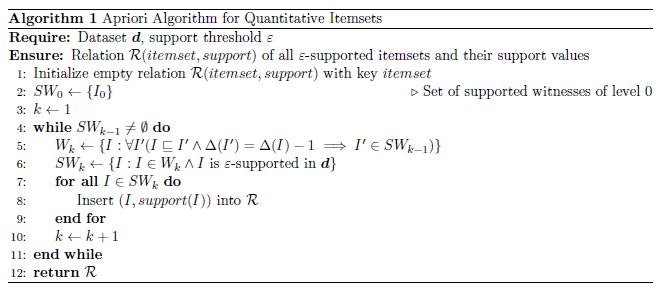

In [ ]:
def apriori_quantitative(df, A_cols, maxi, eps):
    """
    Algorithm 1 - Apriori per itemset quantitativi.
    Ritorna R: dict { itemset_key -> support } degli itemset supported trovati
    """
    # inizializzazione empty relation R(itemset, support)
    R = {}

    # SW0 <- {I0}
    I0 = {a: (0, maxi[a]) for a in A_cols}
    SW_prev = {key_of(I0, A_cols)}

    # k <- 1
    k = 1

    # while SW_{k-1} != empty
    while SW_prev:
        #   - generare candidati stringendo di 1 (successors) da SW_{k-1}
        #   - Continua finché al livello precedente esistono itemset supportati
        candidates = set()
        for pkey in SW_prev:
            P = from_key(pkey, A_cols)
            for child in successors(P, A_cols):  # Δ+1
                candidates.add(key_of(child, A_cols))

        Wk = set() # nuovi itemset ottenuti restringendo quelli del livello precedente
        for ckey in candidates:
            I = from_key(ckey, A_cols)

            ok = True
            for parent in predecessors(I, maxi, A_cols): 
                if key_of(parent, A_cols) not in SW_prev:
                    ok = False
                    break

            if ok:
                Wk.add(ckey)

        # SWk <- {I : I in Wk and I is supported}
        SW_k = set()
        for ckey in Wk:
            I = from_key(ckey, A_cols)
            s = support(df, I, A_cols)
            if s >= eps:
                SW_k.add(ckey)

        # for all I in SWk: Insert (I, support(I)) into R
        for ckey in SW_k:
            I = from_key(ckey, A_cols)
            R[ckey] = support(df, I, A_cols)

        # k <- k + 1
        SW_prev = SW_k # insieme degli itemset supportati del livello precedent
        k += 1

    return R


In [510]:
R = apriori_quantitative(df, A_cols, maxi, eps)
print("R size:", len(R))
print("\nItemset trovati (key -> support):")
for k, s in R.items():
    print(k, "support =", s)


R size: 299

Itemset trovati (key -> support):
((0, 9), (0, 7), (0, 5)) support = 0.8181818181818182
((0, 9), (0, 7), (1, 6)) support = 0.9090909090909091
((0, 9), (1, 7), (0, 6)) support = 0.9090909090909091
((1, 9), (0, 7), (0, 6)) support = 0.9090909090909091
((0, 9), (0, 6), (0, 6)) support = 0.5454545454545454
((0, 8), (0, 7), (0, 6)) support = 0.5454545454545454
((1, 9), (1, 7), (0, 6)) support = 0.9090909090909091
((1, 9), (0, 7), (0, 5)) support = 0.8181818181818182
((0, 9), (1, 7), (0, 5)) support = 0.8181818181818182
((0, 7), (0, 7), (0, 6)) support = 0.5454545454545454
((0, 9), (0, 6), (0, 5)) support = 0.5454545454545454
((0, 9), (0, 7), (1, 5)) support = 0.8181818181818182
((0, 8), (1, 7), (0, 6)) support = 0.5454545454545454
((0, 9), (2, 7), (0, 6)) support = 0.9090909090909091
((0, 9), (0, 6), (1, 6)) support = 0.5454545454545454
((0, 8), (0, 7), (1, 6)) support = 0.5454545454545454
((0, 9), (0, 7), (2, 6)) support = 0.6363636363636364
((0, 9), (1, 7), (1, 6)) support = 

# RANDOMIC A PRIORI

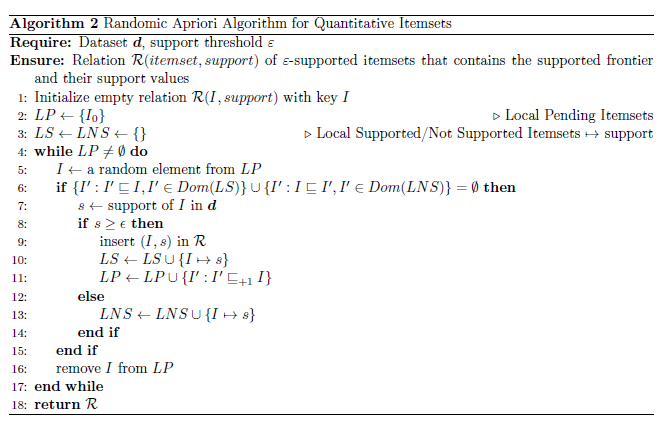

In [ ]:
def leq_key(k1, k2):
    """
    True k1 più specifico o uguale a k2 -> (b1,e1) contenuto in (b2,e2)
    <=> b2 <= b1 e e1 <= e2
    """
    for (b1, e1), (b2, e2) in zip(k1, k2):
        if not (b2 <= b1 and e1 <= e2):
            return False
    return True


In [ ]:
def randomic_apriori_quantitative(df, A_cols, maxi, eps, seed=0):
    """
    Algorithm 2 - Randomc apriori per itemset quantitativi.
    """
    rng = random.Random(seed)

    R = set()      # insieme degli itemset supported trovati
    I0 = {a: (0, maxi[a]) for a in A_cols}
    k0 = key_of(I0, A_cols)
    LP = {k0}

    LS = set()     # Dom(LS): itemset supportati 
    LNS = set()    # Dom(LNS): itemset non supportati

    while LP:
        ikey = rng.choice(tuple(LP))
        I = from_key(ikey, A_cols)

        # pruning condition 
        exists_more_specific_supported = any(leq_key(skey, ikey) for skey in LS)
        exists_more_general_not_supported = any(leq_key(ikey, nskey) for nskey in LNS)

        if exists_more_general_not_supported:
            # I non supportato 
            LNS.add(ikey)

        ##
        elif exists_more_specific_supported:
            # I supportato
            LS.add(ikey)
            R.add(ikey)
            for child in successors(I, A_cols):
                LP.add(key_of(child, A_cols))

        else:
            s = support(df, I, A_cols)
            if s >= eps:
                LS.add(ikey)
                R.add(ikey)
                for child in successors(I, A_cols):
                    LP.add(key_of(child, A_cols))
            else:
                LNS.add(ikey)

        LP.remove(ikey)

    return R, LS, LNS


In [ ]:
R2, LS2, LNS2 = randomic_apriori_quantitative(
    df, A_cols, maxi, eps=eps, seed=1
)

print("Supported itemsets found:", len(R2))
print("LS size:", len(LS2))
print("LNS size:", len(LNS2))

for k in list(R2)[:10]:
    print(k)


Supported itemsets found: 300
LS size: 300
LNS size: 860
((1, 6), (2, 7), (0, 6))
((1, 8), (1, 7), (1, 6))
((0, 9), (2, 7), (2, 5))
((1, 9), (0, 7), (0, 5))
((0, 7), (5, 7), (0, 6))
((1, 9), (2, 6), (0, 6))
((1, 9), (5, 7), (0, 6))
((0, 4), (2, 7), (1, 6))
((0, 9), (2, 7), (0, 6))
((0, 4), (4, 7), (0, 6))


In [516]:
for k in list(R2)[:10]:
    I = from_key(k, A_cols)
    s = support(df, I, A_cols)
    print(k, "support =", s)


((1, 6), (2, 7), (0, 6)) support = 0.5454545454545454
((1, 8), (1, 7), (1, 6)) support = 0.5454545454545454
((0, 9), (2, 7), (2, 5)) support = 0.5454545454545454
((1, 9), (0, 7), (0, 5)) support = 0.8181818181818182
((0, 7), (5, 7), (0, 6)) support = 0.5454545454545454
((1, 9), (2, 6), (0, 6)) support = 0.5454545454545454
((1, 9), (5, 7), (0, 6)) support = 0.5454545454545454
((0, 4), (2, 7), (1, 6)) support = 0.5454545454545454
((0, 9), (2, 7), (0, 6)) support = 0.9090909090909091
((0, 4), (4, 7), (0, 6)) support = 0.5454545454545454


In [ ]:
R_classic = apriori_quantitative(df, A_cols, maxi, eps=eps)
R_random, _, _ = randomic_apriori_quantitative(df, A_cols, maxi, eps=eps, seed=1)

print("Classic:", len(R_classic))
print("Randomic:", len(R_random))
print("Missing from randomic:", len(set(R_classic.keys()) - R_random))


Classic: 299
Randomic: 300
Missing from randomic: 0


In [518]:
extra = R_random - set(R_classic.keys())
print(len(extra))
print(list(extra)[:5])


1
[((0, 9), (0, 7), (0, 6))]


In [519]:
# #CHECK 
# R1 = apriori_quantitative(df, A_cols, maxi, eps=0.5)
# R2 = randomic_apriori_quantitative(df, A_cols, maxi, eps=0.5, seed=1)

# print("R2 subset of R1?", set(R2.keys()).issubset(set(R1.keys())))

# I0 = tuple((0, maxi[a]) for a in A_cols)

# print("I0 in R2?", I0 in R2)
# print("I0 in R1?", I0 in R1)
# R2_no_I0 = {k:v for k,v in R2.items() if k != I0}

# print("R2 \\ {I0} subset of R1?",
#       set(R2_no_I0.keys()).issubset(set(R1.keys())))


# RANDOMIC DISTRIBUTED A PRIORI

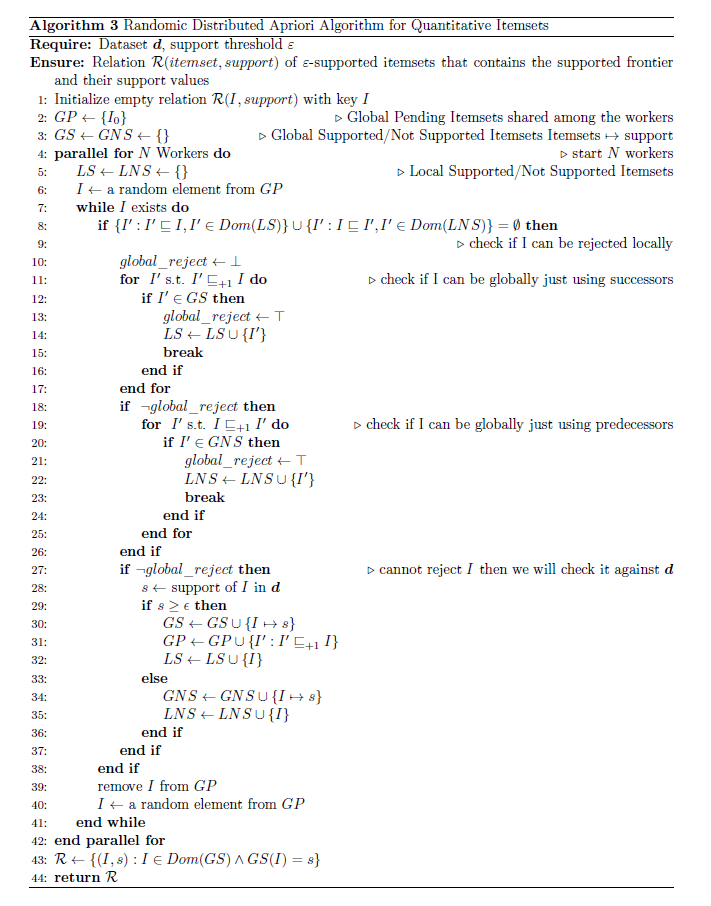

In [ ]:
def randomic_distributed_apriori_quantitative(
    df, A_cols, maxi, eps, n_workers=4, seed=0, max_steps=10_000_000
):
    """
    Algorithm 3 - Randomic Distributed Apriori
    Ritorna R: dict { itemset_key -> support } di itemset supported
    """

    # GP <- {I0}
    I0 = {a: (0, maxi[a]) for a in A_cols}
    k0 = key_of(I0, A_cols)
    GP = {k0}

    # GS, GNS: itemset -> support
    GS = {}
    GNS = {}

    workers = [
        {"rng": random.Random(seed + w), "LS": set(), "LNS": set()}
        for w in range(n_workers)
    ]

    def pick_from_GP(rng):
        if not GP:
            return None
        return rng.choice(tuple(GP))

    steps = 0
    widx = 0

    # parallel for N workers do
    while GP:
        steps += 1
        if steps > max_steps:
            raise RuntimeError("Alg3: max_steps raggiunto")

        w = workers[widx]
        widx = (widx + 1) % n_workers

        rng, LS, LNS = w["rng"], w["LS"], w["LNS"]
        ikey = pick_from_GP(rng)
        if ikey is None:
            break

        I = from_key(ikey, A_cols)

        # se posso scartare localmente, non faccio nulla e rimuovo da GP
        exists_more_specific_supported = any(leq_key(skey, ikey) for skey in LS)
        exists_more_general_not_supported = any(leq_key(ikey, nskey) for nskey in LNS)

        if not (exists_more_specific_supported or exists_more_general_not_supported):

            global_reject = False
            for I_prime in successors(I, A_cols):
                k_prime = key_of(I_prime, A_cols)
                if k_prime in GS:
                    # se esiste un più specifico supportato, I non è frontier -> scartare I senza support
                    global_reject = True
                    LS.add(k_prime) 
                    break

            if not global_reject:
                for I_prime in predecessors(I, maxi, A_cols):
                    k_prime = key_of(I_prime, A_cols)
                    if k_prime in GNS:
                        # se esiste un più generale non supportato, I non supportato -> scartare senza support
                        global_reject = True
                        LNS.add(k_prime)
                        break

            # se non posso scartare, calcolo supporto
            if not global_reject:
                s = support(df, I, A_cols)
                if s >= eps:
                    GS[ikey] = s
                    # aggiungo più specifici di 1 (successors)
                    for I_prime in successors(I, A_cols):
                        GP.add(key_of(I_prime, A_cols))
                    LS.add(ikey)
                else:
                    GNS[ikey] = s
                    LNS.add(ikey)

        # remove I from GP
        if ikey in GP:
            GP.remove(ikey)

    R = dict(GS)
    return R


In [ ]:

R3 = randomic_distributed_apriori_quantitative(df, A_cols, maxi, eps=eps, n_workers=4, seed=1)

print("Alg3 -> supported found:", len(R3))
print("Alg3 -> first 5:", list(R3.items())[:5])


Alg3 | supported found: 82
Alg3 | first 5: [(((0, 9), (0, 7), (0, 6)), 0.9090909090909091), (((0, 9), (0, 7), (0, 5)), 0.8181818181818182), (((0, 9), (0, 6), (0, 5)), 0.5454545454545454), (((0, 9), (0, 7), (1, 5)), 0.8181818181818182), (((0, 9), (0, 7), (2, 5)), 0.5454545454545454)]


In [1]:
# from collections import Counter

# def run_alg3_with_stats(df, A_cols, maxi, eps, n_workers=4, seed=0):
#     stats = Counter()

#     I0 = {a: (0, maxi[a]) for a in A_cols}
#     k0 = key_of(I0, A_cols)
#     GP = {k0}
#     GS, GNS = {}, {}

#     workers = [{"rng": random.Random(seed+w), "LS": set(), "LNS": set()} for w in range(n_workers)]

#     def random_from_GP(rng):
#         if not GP:
#             return None
#         return rng.choice(tuple(GP))

#     for w in workers:
#         rng, LS, LNS = w["rng"], w["LS"], w["LNS"]
#         ikey = random_from_GP(rng)

#         while ikey is not None and ikey in GP:
#             stats["picked"] += 1
#             I = from_key(ikey, A_cols)

#             exists_more_specific_supported = any(leq_key(skey, ikey) for skey in LS)
#             exists_more_general_not_supported = any(leq_key(ikey, nskey) for nskey in LNS)

#             if (not exists_more_specific_supported) and (not exists_more_general_not_supported):
#                 stats["local_empty"] += 1
#                 global_reject = False

#                 for I_prime in successors(I, A_cols):
#                     if key_of(I_prime, A_cols) in GS:
#                         global_reject = True
#                         stats["global_reject_via_GS"] += 1
#                         LS.add(key_of(I_prime, A_cols))
#                         break

#                 if not global_reject:
#                     for I_prime in predecessors(I, maxi, A_cols):
#                         if key_of(I_prime, A_cols) in GNS:
#                             global_reject = True
#                             stats["global_reject_via_GNS"] += 1
#                             LNS.add(key_of(I_prime, A_cols))
#                             break

#                 if not global_reject:
#                     stats["support_computed"] += 1
#                     s = support(df, I, A_cols)
#                     if s >= eps:
#                         GS[ikey] = s
#                         LS.add(ikey)
#                         stats["added_GS"] += 1
#                         before = len(GP)
#                         for I_prime in successors(I, A_cols):
#                             GP.add(key_of(I_prime, A_cols))
#                         stats["gp_added"] += (len(GP) - before)
#                     else:
#                         GNS[ikey] = s
#                         LNS.add(ikey)
#                         stats["added_GNS"] += 1
#             else:
#                 stats["local_not_empty_skip"] += 1

#             GP.remove(ikey)
#             stats["removed"] += 1
#             ikey = random_from_GP(rng)

#     return dict(GS), dict(GNS), stats

# GS, GNS, stats = run_alg3_with_stats(df, A_cols, maxi, eps=eps, n_workers=4, seed=1)
# print(stats)
# print("GS:", len(GS), "GNS:", len(GNS))


In [524]:
# I0_key = tuple((0, maxi[a]) for a in A_cols)

# print(set(R3.keys()) - {I0_key} <= set(R1.keys()))


# ESERCIZIO 2

### CALCOLO frontier itemset R Dom(GS)

In [525]:
def frontier_itemsets(R, A_cols):
    """
    R: dict {itemset_key -> support} di tutti gli itemset supportati
    Ritorna:
      - F: dict {itemset_key -> support} contenente solo gli itemset di frontiera.

    """
    R_keys = set(R.keys())
    F = {}

    for ikey, isupp in R.items():
        I = from_key(ikey, A_cols)
        has_supported_successor = False

        for child in successors(I, A_cols):
            ckey = key_of(child, A_cols)
            if ckey in R_keys:
                has_supported_successor = True
                break

        if not has_supported_successor:
            F[ikey] = isupp

    return F


In [ ]:
R1 = apriori_quantitative(df, A_cols, maxi, eps=eps)
F1 = frontier_itemsets(R1, A_cols)         
F1_keys = set(F1)                        

R3 = randomic_distributed_apriori_quantitative(df, A_cols, maxi, eps=eps, n_workers=4, seed=1)
R3_keys = set(R3)                          

print("Frontier Alg1:", len(F1_keys))
print("Alg3 keys:", len(R3_keys))
print("Missing frontier from Alg3:", len(F1_keys - R3_keys))


Frontier Alg1: 2
Alg3 keys: 82
Missing frontier from Alg3: 0


In [ ]:
R1 = apriori_quantitative(df, A_cols, maxi, eps)
F1 = frontier_itemsets(R1, A_cols)
F1_keys = set(F1)  

R2_out = randomic_apriori_quantitative(df, A_cols, maxi, eps)
R2_keys = set(R2_out[0])          

R3 = randomic_distributed_apriori_quantitative(df, A_cols, maxi, eps)
R3_keys = set(R3)              

assert F1_keys <= R2_keys
assert F1_keys <= R3_keys


In [ ]:
F = frontier_itemsets(R1, A_cols)

print("Frontier size:", len(F))
for k, s in F.items():
    print(k, s)
for k in F: 
    I = from_key(k, A_cols)
    assert all(key_of(ch, A_cols) not in R1 for ch in successors(I, A_cols))


Frontier size: 2
((1, 9), (2, 6), (2, 3)) 0.5454545454545454
((1, 3), (5, 7), (1, 6)) 0.5454545454545454


In [529]:
from itertools import combinations

def all_nontrivial_subsets(items):
    """
    items: lista 
    ritorna tutti i sottoinsiemi non vuoti e non completi
    """
    subsets = []
    n = len(items)
    for k in range(1, n):
        for comb in combinations(items, k):
            subsets.append(set(comb))
    return subsets


In [ ]:
def generate_rules_from_frontier(F, A_cols):
    """
    F: dict {itemset_key -> support}
    Ritorna lista di regole (antecedent_dict, consequent_dict, full_itemset_key)
    """
    rules = []

    for ikey in F.keys():
        I = from_key(ikey, A_cols)
        attrs = list(A_cols)

        for A_set in all_nontrivial_subsets(attrs):
            B_set = set(attrs) - A_set

            antecedent = {a: I[a] for a in A_set}
            consequent = {a: I[a] for a in B_set}

            rules.append((antecedent, consequent, ikey))

    return rules


In [531]:
F = frontier_itemsets(R1, A_cols)
rules = generate_rules_from_frontier(F, A_cols)

m = len(A_cols)
expected = len(F) * (2**m - 2)

print("Frontier size:", len(F))
print("Rules generated:", len(rules))
print("Expected:", expected)
for ant, cons, ikey in rules[:5]:
    print("ANT:", ant, "--> CONS:", cons)


Frontier size: 2
Rules generated: 12
Expected: 12
ANT: {'A': (1, 9)} --> CONS: {'D': (2, 3), 'B': (2, 6)}
ANT: {'B': (2, 6)} --> CONS: {'D': (2, 3), 'A': (1, 9)}
ANT: {'D': (2, 3)} --> CONS: {'A': (1, 9), 'B': (2, 6)}
ANT: {'A': (1, 9), 'B': (2, 6)} --> CONS: {'D': (2, 3)}
ANT: {'D': (2, 3), 'A': (1, 9)} --> CONS: {'B': (2, 6)}


 ## CONFIDENCE

In [532]:
def confidence(df, ant, ikey, R, A_cols):
    supp_I = R[ikey]
    supp_A = support(df, ant, A_cols)
    return 0.0 if supp_A == 0 else supp_I / supp_A

In [533]:
CONF_TH = 0.8
rules_conf = []

for ant, cons, ikey in rules:
    conf = confidence(df, ant, ikey, R1, A_cols)
    if conf >= CONF_TH:
        rules_conf.append((ant, cons, ikey, conf))

print("Rules with conf>=0.8:", len(rules_conf))
print("Max conf:", max(c for *_, c in rules_conf) if rules_conf else None)


Rules with conf>=0.8: 10
Max conf: 1.0


In [534]:
# for ant, cons, _, conf in rules_conf:
#     print(ant, "→", cons, "confidence =", conf)


In [535]:
# # CHECK
# for ant, cons, ikey in rules:
#     supp_I = R1[ikey]
#     supp_A = support(df, ant, list(ant.keys()))
#     conf = supp_I / supp_A if supp_A > 0 else 0
#     print("ant:", ant, "supp_A:", supp_A, "| supp_I:", supp_I, "| conf:", conf)


## LIFT

- lift = 1 → A e B sono “indipendenti” (A non cambia la probabilità di B)
- lift > 1 → A aumenta la probabilità di B (associazione positiva)
- lift < 1 → A riduce la probabilità di B (associazione negativa)

In [536]:
def lift_(df, ant, cons, ikey, R, A_cols):
    supp_I = R[ikey]
    supp_A = support(df, ant, A_cols)       
    supp_B = support(df, cons, A_cols)       
    if supp_A == 0 or supp_B == 0:
        return 0.0
    return supp_I / (supp_A * supp_B)


In [537]:
rules_conf_lift = []

for ant, cons, ikey, conf in rules_conf:
    lift = lift_(df, ant, cons, ikey, R1, A_cols)
    rules_conf_lift.append((ant, cons, ikey, conf, lift))

print("Rules after adding lift:", len(rules_conf_lift))


Rules after adding lift: 10


In [538]:
# for ant, cons, ikey, conf in rules_conf[:10]:
#     l = lift_(df, ant, cons, ikey, R1, A_cols)
#     print("conf:", conf, "lift:", l)


In [539]:
# for ant, cons, ikey in rules[:20]:
#     supp_I = R1[ikey]
#     supp_A = support(df, ant, A_cols)
#     supp_B = support(df, cons, A_cols)
#     if supp_I - supp_A > 1e-12 or supp_I - supp_B > 1e-12:
#         print("WARNING inconsistent:", ikey, supp_I, supp_A, supp_B)
#         break


## P-VALUE

In [540]:
import numpy as np

def mask_satisfy(df, itemset):
    """
    itemset: dict {attr -> (b,e)} 
    ritorna una mask booleana sulle righe del dataframe
    """
    mask = np.ones(len(df), dtype=bool)
    for a, (b, e) in itemset.items():
        x = df[a].to_numpy()
        mask &= (b < x) & (x < e)
    return mask


In [541]:
def contingency_2x2_weighted(df, ant, cons):
    """
    Ritorna la tabella 2×2 (n11, n10, n01, n00) pesata con C
    per la rule ant -> cons
    """
    w = df["C"].to_numpy()

    A = mask_satisfy(df, ant)
    B = mask_satisfy(df, cons)

    n11 = w[A & B].sum()          # A e B
    n10 = w[A & (~B)].sum()       # A e non B
    n01 = w[(~A) & B].sum()       # non A e B
    n00 = w[(~A) & (~B)].sum()    # non A e non B

    return n11, n10, n01, n00


In [542]:
from scipy.stats import chi2_contingency

def p_value_chi2(df, ant, cons, correction=False):
    """
    Calcola il p-value (X2) per la rule ant -> cons.
    """
    n11, n10, n01, n00 = contingency_2x2_weighted(df, ant, cons)

    table = np.array([[n11, n10],
                      [n01, n00]], dtype=float)

    chi2, p_value, dof, expected = chi2_contingency(
        table, correction=correction
    )

    return p_value


In [543]:
rules_final = []

for ant, cons, ikey, conf, lift in rules_conf_lift:
    p = p_value_chi2(df, ant, cons, correction=True)  
    if lift > 1.5 and p < 0.05:
        rules_final.append((ant, cons, ikey, conf, lift, p))

print("Final significant rules:", len(rules_final))


Final significant rules: 8


In [544]:
# ordina per lift (o conf)
rules_sorted = sorted(rules_final, key=lambda x: x[4], reverse=True)

for ant, cons, ikey, conf, lift, p in rules_sorted[:10]:
    print("ANT:", ant)
    print("CONS:", cons)
    print(f"conf={conf:.3f}, lift={lift:.3f}, p={p:.5f}")
    print("-"*40)


ANT: {'D': (2, 3)}
CONS: {'A': (1, 9), 'B': (2, 6)}
conf=1.000, lift=1.833, p=0.00676
----------------------------------------
ANT: {'A': (1, 9), 'B': (2, 6)}
CONS: {'D': (2, 3)}
conf=1.000, lift=1.833, p=0.00676
----------------------------------------
ANT: {'A': (1, 3)}
CONS: {'D': (1, 6), 'B': (5, 7)}
conf=1.000, lift=1.833, p=0.00676
----------------------------------------
ANT: {'B': (5, 7)}
CONS: {'D': (1, 6), 'A': (1, 3)}
conf=1.000, lift=1.833, p=0.00676
----------------------------------------
ANT: {'D': (1, 6), 'A': (1, 3)}
CONS: {'B': (5, 7)}
conf=1.000, lift=1.833, p=0.00676
----------------------------------------
ANT: {'D': (1, 6), 'B': (5, 7)}
CONS: {'A': (1, 3)}
conf=1.000, lift=1.833, p=0.00676
----------------------------------------
ANT: {'B': (2, 6)}
CONS: {'D': (2, 3), 'A': (1, 9)}
conf=0.857, lift=1.571, p=0.03426
----------------------------------------
ANT: {'D': (2, 3), 'A': (1, 9)}
CONS: {'B': (2, 6)}
conf=1.000, lift=1.571, p=0.03426
-------------------------

In [545]:
print(len(F))       # frontier (es: 2)
print(len(rules))   # deve essere = |F| * (2^|A_cols| - 2)
print(len(rules_conf))
print(len(rules_final))


2
12
10
8


In [546]:
rules_sorted = sorted(rules_final, key=lambda x: x[4], reverse=True)  # lift index=4
for ant, cons, ikey, conf, lift, p in rules_sorted:
    print(f"conf={conf:.3f} lift={lift:.3f} p={p:.5f} | {ant} -> {cons}")


conf=1.000 lift=1.833 p=0.00676 | {'D': (2, 3)} -> {'A': (1, 9), 'B': (2, 6)}
conf=1.000 lift=1.833 p=0.00676 | {'A': (1, 9), 'B': (2, 6)} -> {'D': (2, 3)}
conf=1.000 lift=1.833 p=0.00676 | {'A': (1, 3)} -> {'D': (1, 6), 'B': (5, 7)}
conf=1.000 lift=1.833 p=0.00676 | {'B': (5, 7)} -> {'D': (1, 6), 'A': (1, 3)}
conf=1.000 lift=1.833 p=0.00676 | {'D': (1, 6), 'A': (1, 3)} -> {'B': (5, 7)}
conf=1.000 lift=1.833 p=0.00676 | {'D': (1, 6), 'B': (5, 7)} -> {'A': (1, 3)}
conf=0.857 lift=1.571 p=0.03426 | {'B': (2, 6)} -> {'D': (2, 3), 'A': (1, 9)}
conf=1.000 lift=1.571 p=0.03426 | {'D': (2, 3), 'A': (1, 9)} -> {'B': (2, 6)}


## VISUALIZATION

In [547]:
def itemset_to_string(itemset):
    """
    itemset: dict {attr -> (b,e)}
    ritorna una stringa leggibile tipo:
    '1 < A < 3 AND 5 < B < 7'
    """
    parts = []
    for a, (b, e) in itemset.items():
        parts.append(f"{b} < {a} < {e}")
    return " AND ".join(parts)

def print_rule(ant, cons, conf, lift, pval):
    ant_str = itemset_to_string(ant)
    cons_str = itemset_to_string(cons)

    print(f"{ant_str}  →  {cons_str}")
    print(f"   confidence = {conf:.3f}")
    print(f"   lift       = {lift:.3f}")
    print(f"   p-value    = {pval:.5f}")
    print()


In [548]:
for ant, cons, ikey, conf in rules_conf:
    lift_val =  lift_(df, ant, cons, ikey, R1, A_cols)
    pval = p_value_chi2(df, ant, cons)

    print_rule(ant, cons, conf, lift_val, pval)


2 < B < 6  →  2 < D < 3 AND 1 < A < 9
   confidence = 0.857
   lift       = 1.571
   p-value    = 0.00602

2 < D < 3  →  1 < A < 9 AND 2 < B < 6
   confidence = 1.000
   lift       = 1.833
   p-value    = 0.00091

1 < A < 9 AND 2 < B < 6  →  2 < D < 3
   confidence = 1.000
   lift       = 1.833
   p-value    = 0.00091

2 < D < 3 AND 1 < A < 9  →  2 < B < 6
   confidence = 1.000
   lift       = 1.571
   p-value    = 0.00602

2 < D < 3 AND 2 < B < 6  →  1 < A < 9
   confidence = 1.000
   lift       = 1.100
   p-value    = 0.25059

1 < A < 3  →  1 < D < 6 AND 5 < B < 7
   confidence = 1.000
   lift       = 1.833
   p-value    = 0.00091

5 < B < 7  →  1 < D < 6 AND 1 < A < 3
   confidence = 1.000
   lift       = 1.833
   p-value    = 0.00091

1 < A < 3 AND 5 < B < 7  →  1 < D < 6
   confidence = 1.000
   lift       = 1.100
   p-value    = 0.25059

1 < D < 6 AND 1 < A < 3  →  5 < B < 7
   confidence = 1.000
   lift       = 1.833
   p-value    = 0.00091

1 < D < 6 AND 5 < B < 7  →  1 < A < 3

# ESERCIZIO 3

In [549]:
PV_TH = 0.05
LIFT_TH = 1.5

final_rules = []
for ant, cons, ikey, conf in rules_conf:
    lift_val =  lift_(df, ant, cons, ikey, R1, A_cols)
    pval = p_value_chi2(df, ant, cons, correction=False)
    if (pval < PV_TH) and (lift_val > LIFT_TH):
        final_rules.append((ant, cons, ikey, conf, lift_val, pval))

print("N final rules:", len(final_rules))
# opzionale: stampa le prime
for ant, cons, _, conf, lift_val, pval in final_rules[:10]:
    print(ant, "→", cons, "| conf", conf, "| lift", lift_val, "| p", pval)


N final rules: 8
{'B': (2, 6)} → {'D': (2, 3), 'A': (1, 9)} | conf 0.8571428571428571 | lift 1.5714285714285716 | p 0.006024843015809131
{'D': (2, 3)} → {'A': (1, 9), 'B': (2, 6)} | conf 1.0 | lift 1.8333333333333335 | p 0.0009111188771537133
{'A': (1, 9), 'B': (2, 6)} → {'D': (2, 3)} | conf 1.0 | lift 1.8333333333333335 | p 0.0009111188771537133
{'D': (2, 3), 'A': (1, 9)} → {'B': (2, 6)} | conf 1.0 | lift 1.5714285714285716 | p 0.006024843015809131
{'A': (1, 3)} → {'D': (1, 6), 'B': (5, 7)} | conf 1.0 | lift 1.8333333333333335 | p 0.0009111188771537133
{'B': (5, 7)} → {'D': (1, 6), 'A': (1, 3)} | conf 1.0 | lift 1.8333333333333335 | p 0.0009111188771537133
{'D': (1, 6), 'A': (1, 3)} → {'B': (5, 7)} | conf 1.0 | lift 1.8333333333333335 | p 0.0009111188771537133
{'D': (1, 6), 'B': (5, 7)} → {'A': (1, 3)} | conf 1.0 | lift 1.8333333333333335 | p 0.0009111188771537133


In [550]:
# COSTRUZIONE ANT CONS
def itemset_to_pairs(itemset_dict):
    # itemset_dict: {attr: (b,e)}
    return {(attr, tuple(interval)) for attr, interval in itemset_dict.items()}

Ant = set()
Cons = set()

for ant, cons, *_ in final_rules:
    Ant |= itemset_to_pairs(ant)
    Cons |= itemset_to_pairs(cons)

print("Ant size:", len(Ant))
print("Cons size:", len(Cons))


Ant size: 6
Cons size: 6


In [551]:
def sup_singleton(df, attr, interval):
    return support(df, {attr: interval})

def Cl(df, Ant_prime):
    """
    Ant_prime: insieme di (attr, (b,e))
    ritorna un itemset dict {attr: (b,e)} 
    """
    best = {}
    for attr, interval in Ant_prime:
        s = sup_singleton(df, attr, interval)
        if attr not in best:
            best[attr] = (interval, s)
        else:
            cur_interval, cur_s = best[attr]
            if (s > cur_s) or (s == cur_s and interval < cur_interval):
                best[attr] = (interval, s)
    return {a: iv for a, (iv, s) in best.items()}


In [552]:
import numpy as np

def j_measure_weighted(df, ant_itemset, cons_itemset):
    """
    ant_itemset: dict {attr:(b,e)} 
    cons_itemset: dict {attr:(b,e)} 
    usa pesi C come probabilità.
    """
    w = df["C"].to_numpy().astype(float)
    N = w.sum()
    if N == 0:
        return 0.0

    A = mask_satisfy(df, ant_itemset) if len(ant_itemset) > 0 else np.ones(len(df), dtype=bool)
    B = mask_satisfy(df, cons_itemset)

    n11 = w[A & B].sum()
    n10 = w[A & (~B)].sum()
    n01 = w[(~A) & B].sum()
    n00 = w[(~A) & (~B)].sum()

    p11 = n11 / N
    p10 = n10 / N
    pB = (n11 + n01) / N
    pNotB = 1 - pB

    denomA = (n11 + n10)
    if denomA == 0:
        return 0.0

    pB_A = n11 / denomA
    pNotB_A = 1 - pB_A

    # Evita log(0) 
    eps = 1e-12
    pB = max(pB, eps)
    pNotB = max(pNotB, eps)
    pB_A = max(pB_A, eps)
    pNotB_A = max(pNotB_A, eps)

    return p11 * np.log(pB_A / pB) + p10 * np.log(pNotB_A / pNotB)


In [ ]:
def shapley_for_consequent(df, Ant, cons_pair, M=300, seed=0):
    """
    cons_pair: (j, (b,e))
    ritorna dict { (attr,interval) : shapley_value } per gli elementi in Ant_j
    """
    rng = random.Random(seed)
    j, cons_interval = cons_pair
    cons_itemset = {j: cons_interval}

    players = [p for p in Ant if p[0] != j]  # Ant_j
    if len(players) == 0:
        return {}

    phi = {p: 0.0 for p in players}

    for _ in range(M):
        perm = players[:]
        rng.shuffle(perm)

        coalition = set()
        v_prev = j_measure_weighted(df, Cl(df, coalition), cons_itemset)

        for p in perm:
            coalition.add(p)
            v_new = j_measure_weighted(df, Cl(df, coalition), cons_itemset)
            phi[p] += (v_new - v_prev)
            v_prev = v_new

    # media
    for p in phi:
        phi[p] /= M
    return phi


In [554]:
shapley_results = {}  # cons_pair -> dict(player->phi)

for cons_pair in Cons:
    shapley_results[cons_pair] = shapley_for_consequent(
        df, Ant, cons_pair, M=300, seed=0
    )

print("Computed shapley for consequents:", len(shapley_results))


Computed shapley for consequents: 6


In [555]:
TOPK = 5
for cons_pair, phi in shapley_results.items():
    top = sorted(phi.items(), key=lambda x: x[1], reverse=True)[:TOPK]
    print("\nConsequent:", cons_pair)
    for (attr, interval), val in top:
        print(f"  {attr}{interval}: {val:.6f}")



Consequent: ('D', (2, 3))
  B(2, 6): 0.203952
  A(1, 9): 0.099181
  B(5, 7): 0.020633
  A(1, 3): 0.006854

Consequent: ('A', (1, 3))
  B(5, 7): 0.142431
  D(1, 6): 0.009572
  D(2, 3): -0.011068
  B(2, 6): -0.091206

Consequent: ('B', (2, 6))
  D(2, 3): 0.092554
  A(1, 3): 0.030346
  A(1, 9): -0.028131
  D(1, 6): -0.092206

Consequent: ('D', (1, 6))
  A(1, 9): 0.044139
  A(1, 3): 0.013838
  B(5, 7): 0.005661
  B(2, 6): -0.011650

Consequent: ('A', (1, 9))
  D(1, 6): 0.036740
  D(2, 3): 0.016699
  B(5, 7): 0.003119
  B(2, 6): -0.004571

Consequent: ('B', (5, 7))
  A(1, 3): 0.141221
  D(2, 3): 0.001376
  D(1, 6): 0.000383
  A(1, 9): -0.137478


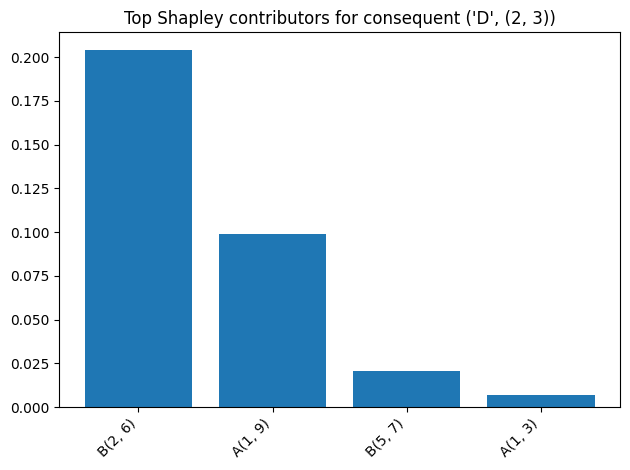

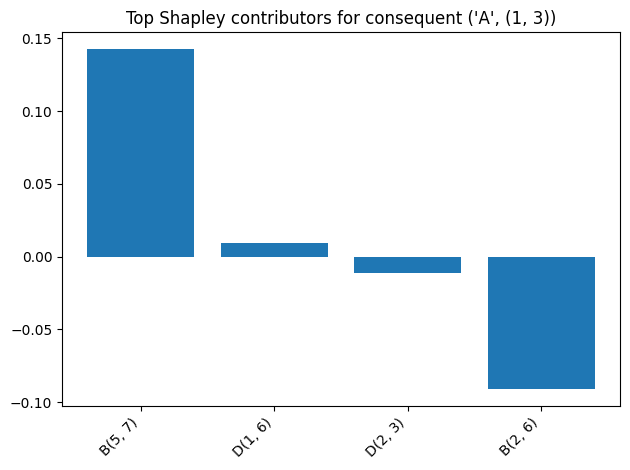

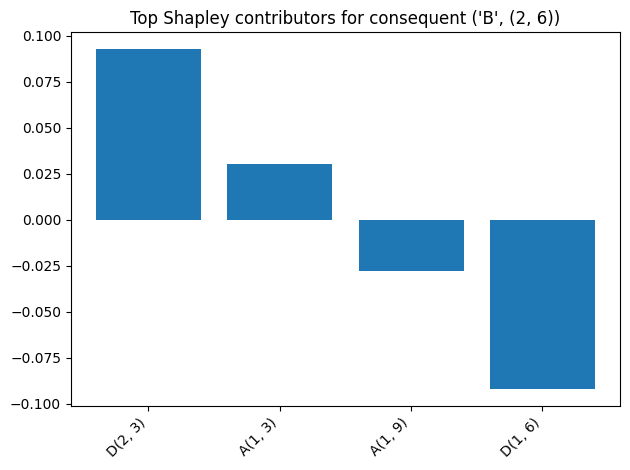

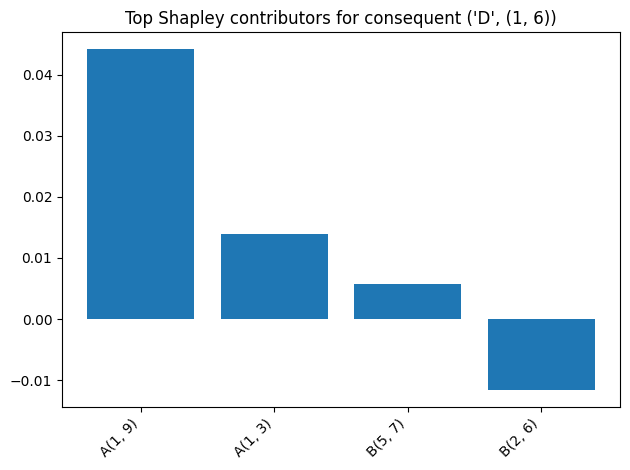

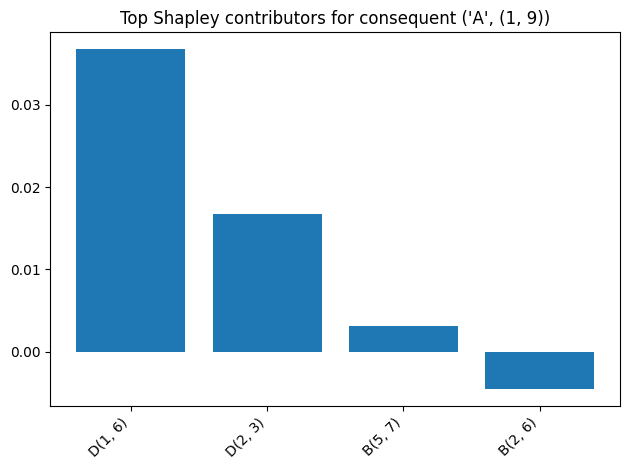

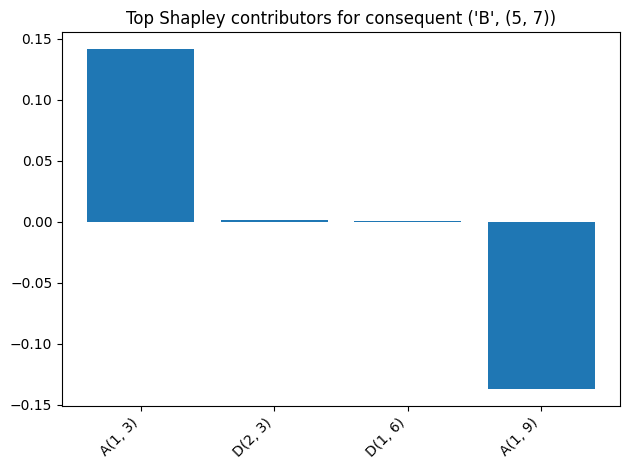

In [556]:
import matplotlib.pyplot as plt

def plot_top_shapley(shapley_results, topk=8):
    for cons_pair, phi in shapley_results.items():
        items = sorted(phi.items(), key=lambda x: x[1], reverse=True)[:topk]
        labels = [f"{a}{iv}" for (a, iv), _ in items]
        values = [v for _, v in items]

        plt.figure()
        plt.bar(range(len(values)), values)
        plt.xticks(range(len(values)), labels, rotation=45, ha="right")
        plt.title(f"Top Shapley contributors for consequent {cons_pair}")
        plt.tight_layout()
        plt.show()

plot_top_shapley(shapley_results, topk=6)
